In [1]:
%matplotlib inline
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.colors import DivergingNorm
from os.path import exists

In [2]:
dir_path = '/Users/osipova/Documents/LabDocs/Bird_transcriptomics/Transcriptome_for_NectarGenomics/DESeq2_results_Kallisto/'

In [3]:
## Get overal stats of number of genes DE
# load data
file_name = 'up_down_stats.per_tissue.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

# plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
p = sns.color_palette('pastel', n_colors=4)
test_sp = list(set(df['test_species']))

i = 0
for test in test_sp:
    df_f = df[df['test_species'] == test]
    df_f_up = df_f[df_f['direction'] == 'upreg'][['genes', 'tissue']]
    df_f_down = df_f[df_f['direction'] == 'downreg'][['genes', 'tissue']]
    df_merged = pd.merge(df_f_up, df_f_down, on=['tissue'], suffixes=('_up', '_down'))
    df_merged['total'] = df_merged['genes_up'] + df_merged['genes_down']
    
    order=df_merged.sort_values('total', ascending=False)['tissue']
    sns.barplot(ax=axes[i], data=df_merged, x='tissue', y='total', 
                order=order, color=p[3])
    sns.barplot(ax=axes[i], data=df_merged, x='tissue', y='genes_down', 
                order=order, color=p[0])
    axes[i].set(xlabel='', ylabel='genes', title=test)
    axes[i].set_ylim(0, 2500)
    axes[i].tick_params(axis='x', rotation=45)
    i += 1
    
# fig.savefig('general_stats_up_down_per_tissue.pdf', bbox_inches='tight')

IndexError: list index out of range

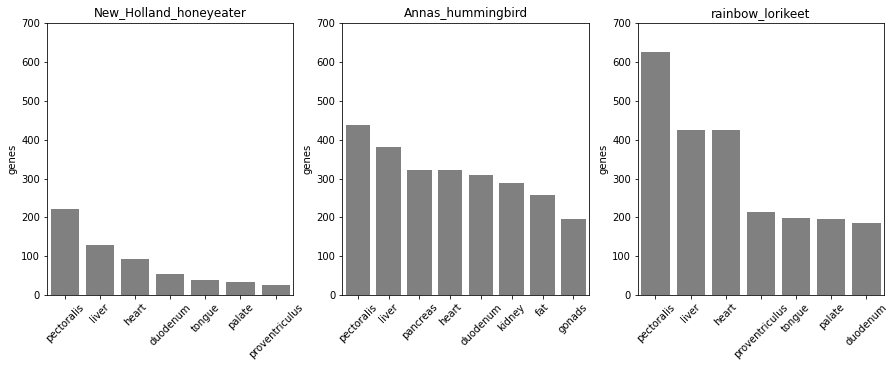

In [12]:
## Get stats for genes with no expression
# load data
file_name = 'zero_stats.per_tissue.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

# plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
p = sns.color_palette('pastel', n_colors=4)

test_sp = list(set(df['test_species']))
i = 0
for test in test_sp:
    df_f = df[df['test_species'] == test]
    order=df_f.sort_values('genes', ascending=False)['tissue']
    sns.barplot(ax=axes[i], data=df_f, x='tissue', y='genes', order=order, color='grey')
    axes[i].set(xlabel='', ylabel='genes', title=test)
    axes[i].set_ylim(0, 700)
    axes[i].tick_params(axis='x', rotation=45)
    i += 1
    
# fig.savefig('zero_expression_genes_per_tissue.pdf', bbox_inches='tight')

In [14]:
## Intentionally left blank

In [340]:
### Clustering genes by tissue vector ###

In [4]:
## Read lables from the info.tsv file into a dictionary
file_name = 'ALL_info.tsv'
d_labels = {}
with open(file_name, 'r') as inf:
    for line in inf.readlines():
        lib = line.split()[0]
        sample = line.split()[1]
        bird = line.split()[2]
        tissue = line.split()[3]
        d_labels[lib] = (sample, bird, tissue)

In [5]:
## Clustering genes by tissue vector
# fig, axes = plt.subplots(1, 6, figsize=(20, 4))

tissues = ['heart', 'fat', 'liver', 'pectoralis', 'pancreas',
          'kidney', 'duodenum', 'proventriculus', 'tongue', 'palate']

pairs = [('Annas_hummingbird', 'common_swift'),
         ('New_Holland_honeyeater', 'zebra_finch'),
         ('rainbow_lorikeet', 'cockatiel')]

all_pairs_dfs = []

for pair in pairs:
    merge_list = []
    test_sp = pair[0]
    ref_sp = pair[1]
    
    ## Merge all tissue datasets
    for tissue in tissues:
        deseq_res_file = 'deseq2_res.{}.{}.{}.tsv'.format(tissue, test_sp, ref_sp)
        deseq_res_file_path = dir_path + deseq_res_file

        # check if file exists
        if exists(deseq_res_file_path):
            d_tissue = pd.read_csv(glob(deseq_res_file_path)[0], sep='\t')
            d_tissue['log10padj'] = - np.log10(d_tissue['padj'])
            d_tissue['log2baseMean'] = np.log2(d_tissue['baseMean'])
            
            # get the target parameter!
            fc = d_tissue['log2FoldChange']
            pval = d_tissue['log10padj']
#             d_tissue[tissue] = fc
#             d_tissue[tissue] = d_tissue['log2baseMean']
#             d_tissue[tissue] = d_tissue['baseMean']
            d_tissue[tissue] = np.sign(fc) * np.sqrt(fc ** 2 + pval ** 2)
    
            d_temp = d_tissue[['gene', tissue]]
            mask = d_temp[tissue] != np.inf
            d_temp.loc[~mask, tissue] = d_temp.loc[mask, tissue].max()
            mask = d_temp[tissue] != -np.inf
            d_temp.loc[~mask, tissue] = d_temp.loc[mask, tissue].min()
            merge_list.append(d_temp)

    dfs = [df.set_index('gene') for df in merge_list]
    df_merged = pd.concat(dfs, axis=1)
    df_merged.fillna(0, inplace=True)
    
    all_pairs_dfs.append(df_merged)

all_pairs_dfs[1].shape

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(11333, 7)

In [7]:
t = all_pairs_dfs[1]
t.head()

,heart,liver,pectoralis,duodenum,proventriculus,tongue,palate
MAP2,-118.668717,-0.902399,-4.822730,-0.485387,-1.942308,0.199578,-3.380589
ABCB1,104.666204,27.849105,10.692723,4.267854,10.557051,18.434490,13.480686
OTULIN,-72.022492,-9.157985,-34.067605,-18.426751,-34.961637,-59.113766,-59.475962
ABCG1,-71.541760,-3.534260,-11.239082,-6.135077,-4.837971,-27.765626,-18.311027
GCNT7,71.232991,75.976222,2.317738,6.161014,-0.673967,2.742386,3.033211


[(0.0, 1000.0), (-50.0, 50.0)]

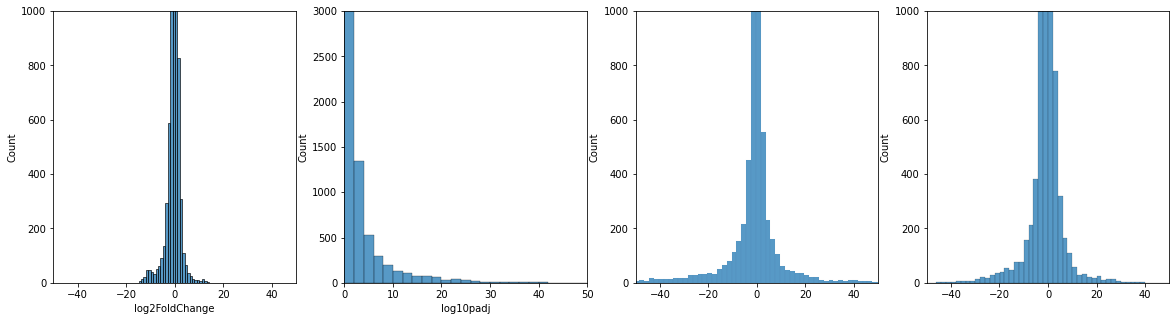

In [32]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
ax1, ax2, ax3, ax4 = axes[0], axes[1], axes[2], axes[3]

sns.histplot(ax=ax1, data=fc, binwidth=1)
sns.histplot(ax=ax2, data=pval, binwidth=2)
sns.histplot(ax=ax3, data=fc * pval, binwidth=2)
sns.histplot(ax=ax4, data=np.sign(fc) * np.sqrt(fc ** 2 + pval ** 2), binwidth=2)

ax1.set(xlim=(-50, 50), ylim=(0, 1000))
ax2.set(xlim=(0, 50), ylim=(0, 3000))
ax3.set(xlim=(-50, 50), ylim=(0, 1000))
ax4.set(xlim=(-50, 50), ylim=(0, 1000))

In [132]:
## Set up heatmap clustering analysis
# fig, axes = plt.subplots(figsize=(3, 40))

# filter for genes with high relevence value
df_relevant = df_merged.loc[(df_merged > 100).any(axis=1) | (df_merged < -100).any(axis=1)]

## cluster gene vectors with K-means and sort by clusters
# model = KMeans(n_clusters=15)
# model.fit(df_relevant)
# df_relevant['clusters'] = model.predict(df_relevant)
# df_relevant_sort = df_relevant.sort_values('clusters')
# df_relevant = df_relevant_sort.drop(columns=['clusters'])

## set palette and center it around 0
gene_min=min(df_relevant.min())
gene_max=max(df_relevant.max())
cmap = sns.diverging_palette(240, 10, as_cmap=True)
divnorm = DivergingNorm(vmin=gene_min, vcenter=0, vmax=gene_max)


## visualize
#visuz.gene_exp.hmap(df=df_relevant, dim=(3, 60), tickfont=(2, 2), figtype='pdf')
# sns.heatmap(df_relevant, cmap='vlag', norm=divnorm)
# g = sns.clustermap(df_relevant, metric="euclidean", 
#                cmap=cmap, norm=divnorm,
#                dendrogram_ratio=(.2, .02),
#                 figsize=(5, 100))

# g.savefig('heatmap_relevant_genes.pdf', bbox_inches='tight')

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


In [ ]:
## Pathways gene clustering analysis

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


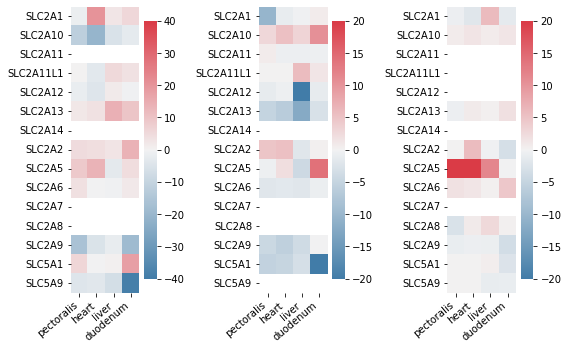

In [8]:
## GLUTs DE expression
# glut_num = ['1', '2', '5', '6', '7', '8', '9', '10', '11', '11L1', '12', '13', '14']
glut_num = ['1', '2', '5', '6', '7', '8', '9', '10', '11', '11L1', '12', '13', '14']
gluts = ['SLC2A{}'.format(i) for i in glut_num] + ['SLC5A1', 'SLC5A9']
tissue_order = ['pectoralis', 'heart', 'liver',  'fat', 'proventriculus', 
                 'duodenum', 'pancreas', 'kidney', 'tongue', 'palate']
limits = [40, 20, 20]
i = 0

fig, axes = plt.subplots(1, 3, figsize=(8, 5))
    
for df_merged in all_pairs_dfs:
    df_gluts = df_merged[df_merged.index.isin(gluts)]
    
    # Assign NaN to all missing GLUTs
#     tissues = df_gluts.columns
#     tissues = ['pectoralis', 'heart', 'liver', 'duodenum', 'palate']
    tissues = ['pectoralis', 'heart', 'liver', 'duodenum']
    df_gluts['gene'] = df_gluts.index
    with_values = df_gluts.index

    for g in list(set(gluts) - set(with_values)):
        d = {t : np.nan for t in tissues}
        d['gene'] = g
        df_gluts = df_gluts.append(d, ignore_index=True)   
    
    df_gluts.set_index('gene', inplace=True)
    df_gluts = df_gluts.sort_index()
    df_gluts = df_gluts[[t for t in tissue_order if t in tissues]]
    
    ## set palette and center it around 0
#     glut_min = min(df_gluts.min())
#     glut_max = max(df_gluts.max())
    glut_min = -limits[i]
    glut_max = limits[i]
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    divnorm = DivergingNorm(vmin=glut_min, vcenter=0, vmax=glut_max)

    ## plot relevance value
    sns.heatmap(ax=axes[i], data=df_gluts, cmap=cmap, norm=divnorm)
#     sns.heatmap(ax=axes[i], data=df_gluts, cmap='Greens')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=40, ha="right")
    axes[i].set_ylabel('')
    fig.tight_layout()
    i += 1

# pdf_name = 'heatmap_GLUTs.relevance_value.ALL_pairs.pdf'
# pdf_name = 'heatmap_GLUTs.log2baseMean.ALL_pairs.pdf'
# pdf_name = 'heatmap_GLUTs.baseMean.ALL_pairs.pdf'
# pdf_name = 'heatmap_GLUTs.distance.ALL_pairs.pdf'
pdf_name = '4_tissues.heatmap_GLUTs.distance.ALL_pairs.pdf'
# pdf_name = 'selected_tissues.heatmap_GLUTs.log2baseMean.ALL_pairs.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

In [8]:
d = all_pairs_dfs[0]
d[d.index == 'SLC2A5']

,heart,fat,liver,pectoralis,pancreas,kidney,duodenum,palate
SLC2A5,14.463634,18.667817,-2.421175,11.514955,10.506054,1.037699,5.424462,14.911105


In [30]:
df_genes

,heart,liver,pectoralis,duodenum,proventriculus,tongue,palate
gene,,,,,,,
HK1,-0.612745,-0.385878,-3.099162,-0.346399,-0.664202,0.133141,-1.052321
HK2,2.151109,-1.372429,0.452237,0.210459,1.546284,-0.044464,-0.056269
HK3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HKDC1,0.595484,-5.678047,1.799689,-1.532924,-2.239302,0.059647,1.220882
GPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PFKL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PFKP,-17.780295,0.957166,0.236940,-0.505152,0.087493,0.568421,-4.551017
PFKFB2,-0.499056,1.157447,1.447972,-0.962308,0.355927,-0.851687,-0.978213
ALDOB,5.424015,4.679530,5.818649,-2.932815,8.600631,0.484620,154.191434


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


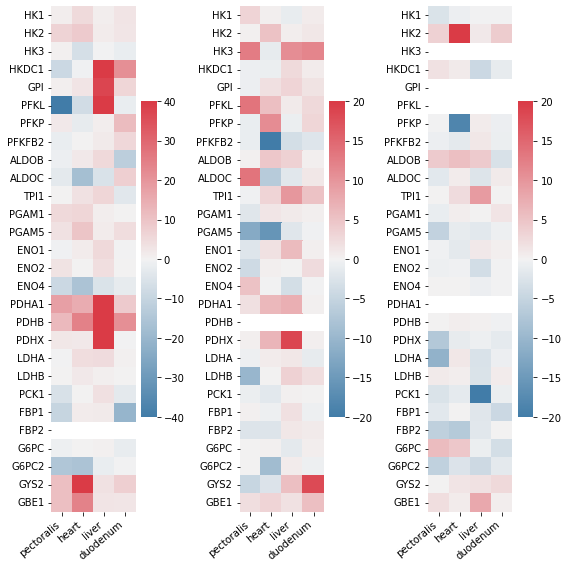

In [9]:
## glycolysis / gluconeogenesis / glycogen synthesis DE expression
excluded = [ 'PFKM', 'GCK', 'GAPDH']
genes = ['HK1', 'HK2', 'HK3', 'HKDC1', 'GPI', 'PFKL',  'PFKP', 'PFKFB2', 
         'ALDOB', 'ALDOC', 'TPI1',  'PGAM1', 'PGAM5', 'ENO1', 'ENO2', 'ENO4',
         'PDHA1', 'PDHB', 'PDHX', 'LDHA', 'LDHB',
         'PCK1', 'FBP1', 'FBP2', 'G6PC', 'G6PC2', 'GYS2', 'GBE1']

limits = [40, 20, 20]
i = 0

fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    
for df_merged in all_pairs_dfs:
    df_genes = df_merged[df_merged.index.isin(genes)]
    
    # Assign NaN to all missing GLUTs
#     tissues = df_genes.columns
#     tissues = ['pectoralis', 'heart', 'liver', 'duodenum', 'palate']
    tissues = ['pectoralis', 'heart', 'liver', 'duodenum']
    df_genes['gene'] = df_genes.index
    with_values = df_genes.index

    for g in list(set(genes) - set(with_values)):
        d = {t : np.nan for t in tissues}
        d['gene'] = g
        df_genes = df_genes.append(d, ignore_index=True)   
    df_genes.set_index('gene', inplace=True)
    df_genes = df_genes.reindex(genes)
    df_genes = df_genes[[t for t in tissue_order if t in tissues]]
    
    ## set palette and center it around 0
    gene_min = -limits[i]
    gene_max = limits[i]
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    divnorm = DivergingNorm(vmin=gene_min, vcenter=0, vmax=gene_max)

    ## plot relevance value
#     sns.heatmap(ax=axes[i], data=df_genes, cmap='Greens')
    sns.heatmap(ax=axes[i], data=df_genes, cmap=cmap, norm=divnorm)

    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=40, ha="right")
    axes[i].set_ylabel('')
    fig.tight_layout()
    i += 1
    
# pdf_name = 'heatmap_glycolysis.relevance_value.ALL_pairs.pdf'
# pdf_name = 'heatmap_glycolysis.log2baseMean.ALL_pairs.pdf'
# pdf_name = 'heatmap_glycolysis.baseMean.ALL_pairs.pdf'
# pdf_name = 'heatmap_glycolysis.distance.ALL_pairs.pdf'
pdf_name = '4_tissues.heatmap_glycolysis.distance.ALL_pairs.pdf'
# pdf_name = 'selected_tissues.heatmap_glycolysis.log2baseMean.ALL_pairs.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


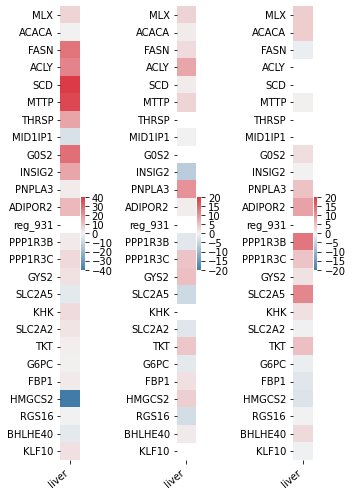

In [10]:
## Genes targets of ChREBP
up_genes = ['mlx', 'slc2a2', 'Khk', 'Tkt', 'Me1', 'Acly', 'Fasn', 
               'Scd', 'G0S2', 'Mttp', 'Pnpla3', 'Dgat2', 'G6pc', 'Fbp1', 
               'PDHA1', 'PDHB', 'Klf10', 'Klf15', 'Bhlhe40', 'Hnf1a', 'Mid1ip1', 
               'Gcgr', 'Adipor2', 'Rgs16', ]
down_genes = ['Pdx1', 'Ins1', 'Ins2', 'Mafa', 'Gck', 'Arnt', 'Ppara', 'Sirt1', 'Inhbe', 'Trib3', 'Slc6A9']
up_lipogenesis = ['mlx', 'Me1', 'Acly', 'Fasn', 'Scd', 'G0S2', 'Mttp', 'Dgat2', 'Adipor2']

schupp_genes = ['Fasn', 'Txnip', 'Acly', 'Mid1ip1', 'G6pc', 'Rgs16', 'Adipor2', 'Hmgcs2', 'Bhlhe40', 
                'Scd', 'Slc2a5', 'Slc2a2', 'G0s2', 
                'Thrsp', 'Khk', 'Klf10', 'Ppp1r3c', 'Ppp1r3b',
                'reg_931', 'Gys2', 'Pnpla3', 'Fbp1', 'Tkt', 'Insig2', 'Mttp']

lipid_genes_schupp = ['MLX','ACACA', 'FASN', 'ACLY', 'SCD', 'MTTP', 'THRSP','MID1IP1', 'G0S2', 
                      'INSIG2', 'PNPLA3', 'ADIPOR2',  'reg_931']
glucose_genes_schupp = ['PPP1R3B', 'PPP1R3C', 'GYS2', 'SLC2A5', 'KHK', 'SLC2A2', 'TKT',
                        'G6PC', 'FBP1', 'HMGCS2']
unknown_genes_schupp = ['RGS16', 'BHLHE40', 'KLF10']

up_genes = [g.upper() for g in up_genes]
down_genes = [g.upper() for g in down_genes]
up_lipogenesis = [g.upper() for g in up_lipogenesis]
schupp_genes = [g.upper() for g in schupp_genes if not (g.startswith('reg_'))] + ['reg_931']

## Define the gene set!
# genes = schupp_genes
genes = lipid_genes_schupp + glucose_genes_schupp + unknown_genes_schupp


limits = [40, 20, 20]
i = 0

fig, axes = plt.subplots(1, 3, figsize=(5, 7))
    
for df_merged in all_pairs_dfs:
    df_genes = df_merged[df_merged.index.isin(genes)]
    
    # Assign NaN to all missing GLUTs
#     tissues = df_genes.columns
#     tissues = ['pectoralis', 'heart', 'liver', 'duodenum']
    tissues = ['liver']
    df_genes['gene'] = df_genes.index
    with_values = df_genes.index

    for g in list(set(genes) - set(with_values)):
        d = {t : np.nan for t in tissues}
        d['gene'] = g
        df_genes = df_genes.append(d, ignore_index=True)   
    df_genes.set_index('gene', inplace=True)
    df_genes = df_genes.reindex(genes)
    df_genes = df_genes[[t for t in tissue_order if t in tissues]]
    
    ## set palette and center it around 0
    gene_min = -limits[i]
    gene_max = limits[i]
#     gene_min = df_genes['liver'].min()
#     gene_max = df_genes['liver'].max()
    
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    divnorm = DivergingNorm(vmin=gene_min, vcenter=0, vmax=gene_max)

    ## plot relevance value
#     sns.heatmap(ax=axes[i], data=df_genes, cmap='Greens')
    sns.heatmap(ax=axes[i], data=df_genes, cmap=cmap, norm=divnorm)

    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=40, ha="right")
    axes[i].set_ylabel('')
    fig.tight_layout()
    i += 1

pdf_name = 'Schupp_targets_Mlxipl.liver.distance.ALL_pairs.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


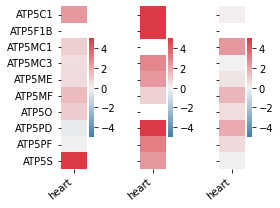

In [11]:
## FA beta-oxidation and synthesis pathways
fa_metabolism_genes = ["ACAT1", "ACAT2", "ACACA", "ACACB", "FASN", "MECR", "OXSM", "MLYCD",
                       "ACADL", "ACADS", "ACADSB", "ACAD8", "ACAD9", "ACAD11", "ACAD6L",
                       "ACAA1", "ACAA2", "ACOX1", "ACOX2", "ACOX3", "ACSL1", "ACSL3", "ACSL4", "ACSL5", "ACSL6",
                       "CPT1A", "CPT2", "CYP4A22", 
                       "ECHS1", "EHHADH", "HADH", "HADHA", "HADHB", "HSD17B10", "HSD17B4",
                       "MLXIPL", 'MLX']

# file_name = 'RAS_list.from_Maggie.lst'
file_name = '/Users/osipova/Documents/LabDocs/NectarivoryProject/Expression_from_counts/t2d_genes.causal_strong.lst'
with open(file_name, 'r') as inf:
    essent_genes = inf.read().rstrip().split('\n')
    
## ATP synthase subunits genes
essent_genes = ['ATP5C1', 'ATP5F1B', 'ATP5MC1', 'ATP5MC3', 'ATP5ME', 'ATP5MF', 'ATP5O',
                'ATP5PD', 'ATP5PF', 'ATP5S']
    
## Define the gene set!
# genes = fa_metabolism_genes
genes = essent_genes

# limits = [20, 20, 20]
limits = [5, 5, 5]
i = 0
fig, axes = plt.subplots(1, 3, figsize=(4, 3))
    
for df_merged in all_pairs_dfs:
    df_genes = df_merged[df_merged.index.isin(genes)]
    
    # Assign NaN to all missing GLUTs
#     tissues = df_genes.columns
#     tissues = ['liver']
    tissues = ['heart']
#     tissues = ['pectoralis', 'heart', 'liver', 'duodenum', 'pancreas', 'palate']
    df_genes['gene'] = df_genes.index
    with_values = df_genes.index

    for g in list(set(genes) - set(with_values)):
        d = {t : np.nan for t in tissues}
        d['gene'] = g
        df_genes = df_genes.append(d, ignore_index=True)   
    df_genes.set_index('gene', inplace=True)
    df_genes = df_genes.reindex(genes)
    df_genes = df_genes[[t for t in tissue_order if t in tissues]]
    
    ## set palette and center it around 0
    gene_min = -limits[i]
    gene_max = limits[i]
#     gene_min = df_genes['liver'].min()
#     gene_max = df_genes['liver'].max()
    
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    divnorm = DivergingNorm(vmin=gene_min, vcenter=0, vmax=gene_max)

    ## plot relevance value
#     sns.heatmap(ax=axes[i], data=df_genes, cmap='Greens')
    sns.heatmap(ax=axes[i], data=df_genes, cmap=cmap, norm=divnorm)

    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=40, ha="right")
    axes[i].set_ylabel('')
    if i != 0:
        axes[i].set_yticklabels('')
    fig.tight_layout()
    i += 1

# pdf_name = 'RAS_genes.6_tissues.distance.ALL_pairs.pdf'
# pdf_name = 'FA_metabolism_genes.liver.distance.ALL_pairs.pdf'
# pdf_name = 't2d_genes.6_tissues.distance.ALL_pairs.pdf'

# pdf_name = 'ATP_syntase_subunits.heart.distance.ALL_pairs.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

In [12]:
df_merged[df_merged.index == 'ACE2']

,heart,liver,pectoralis,duodenum,proventriculus,tongue,palate
ACE2,0.0,3.406997,0.0,-5.375822,0.657374,0.0,0.0
